In [1]:
# import torch
import random
import numpy as np
import matplotlib.pyplot as plt

In [159]:
def intensityHP(t, hist, params):
    # params: [lambda0, alpha, beta]
    # hist must be numpy array
    hist = hist[(hist < t)]
    return params[0] + params[1] * np.sum(np.exp( -1.* (t - hist)/params[2] ))

def genHP(T, params):
    t = 0
    hist = []
    while (t < T):
        upperbnd = intensityHP(t, np.array(hist), params)
        increment = np.random.exponential(1/upperbnd)
        t += increment
        u = random.random()*increment
        if ((t<T) and (u <= intensityHP(t, np.array(hist), params))):
            hist.append(t)
    return {'t': hist, 'x': list(np.ones_like(hist))}

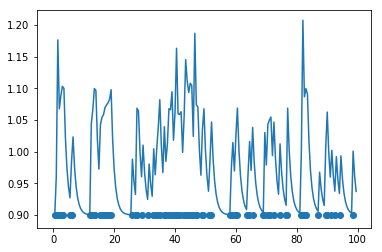

In [160]:
# Hawkes
paramsHP = [.9, .1, 1.]
dataHP = genHP(100, paramsHP)
y_vals = list(map(lambda x: intensityHP(x, np.array(dataHP['t']), paramsHP), np.arange(0, 100, .5)))
plt.plot(np.arange(0,100,.5), y_vals)
plt.scatter(dataHP['t'], [min(y_vals)]*len(dataHP['t']))
plt.show()

In [156]:
def intensitySCP(t, hist, params):
    # params: {mu, alpha}
    # hist must be numpy array
    hist = hist[(hist < t)]
    return np.exp(params[0]*t - np.sum(len(hist)*params[1]))

def genSCP(T, params):
    t = 0
    hist = []
    while (t < T):
        upperbnd = intensitySCP(t+1, np.array(hist), params)
        increment = np.random.exponential(1/upperbnd)
        t += increment
        u = random.random()*increment
        if ((t<T) and (u <= intensitySCP(t, np.array(hist), params))):
            hist.append(t)
    return {'t': hist, 'x': list(np.ones_like(hist))}

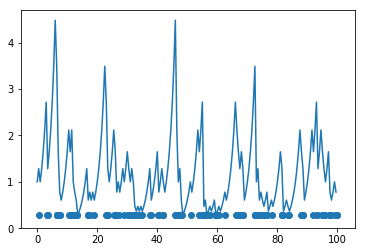

In [158]:
# Self corrcting
paramsSCP = [.5, .5]
dataSCP = genSCP(100, paramsSCP)
y_vals = list(map(lambda x: intensitySCP(x, np.array(dataSCP['t']), paramsSCP), np.arange(0, 100, .5)))
plt.plot(np.arange(0,100,.5), y_vals)
plt.scatter(dataSCP['t'], [min(y_vals)]*len(dataSCP['t']))
plt.show()

In [153]:
def genHomPP(T, params):
    # params = [lambda]
    t = 0
    hist = []
    while (t < T):
        increment = np.random.exponential(1/params[0])
        t += increment
        if ((t<T)):
            hist.append(t)
    return {'t': hist, 'x': list(np.ones_like(hist))}

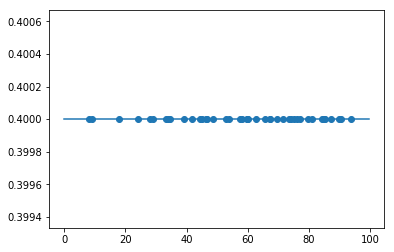

In [155]:
# Homo Poisson
paramsHomPP = [.4]
dataHomPP = genHomPP(100, paramsHomPP)
y_vals = list(map(lambda x: paramsHomPP[0], np.arange(0, 100, .5)))
plt.plot(np.arange(0,100,.5), y_vals)
plt.scatter(dataHomPP['t'], [min(y_vals)]*len(dataHomPP['t']))
plt.show()

In [152]:
def intensityNonHomPP(t, params):
    # params: {alpha}
    return (0.1*np.sin(np.pi*t) + 0.3*np.cos(.4 * np.pi*t) + 1)*.08

def genNonHomPP(T, params):
    t = 0
    hist = []
    while (t < T):
        upperbnd = 2
        increment = np.random.exponential(1/upperbnd)
        t += increment
        u = random.random()*increment
        if ((t<T) and (u <= intensityNonHomPP(t, params))):
            hist.append(t)
    return {'t': hist, 'x': list(np.ones_like(hist))}

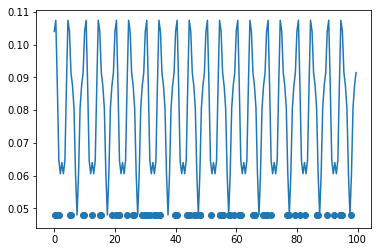

In [150]:
# Homo Poisson
paramsNonHomPP = [.1]
dataNonHomPP = genNonHomPP(100, paramsNonHomPP)
y_vals = list(map(lambda x: intensityNonHomPP(x, paramsNonHomPP), np.arange(0, 100, .5)))
plt.plot(np.arange(0,100,.5), y_vals)
plt.scatter(dataNonHomPP['t'], [min(y_vals)]*len(dataNonHomPP['t']))
plt.show()

In [193]:
def intensitySSCT(r, y, params):
    # params: [a1...am]
    return np.exp(np.dot(params, r*y))

def genpointSSCT(r, y, params):
    intensity = intensitySSCT(np.array(r), np.array(y), params)
    increment = np.random.exponential(1/intensity)
    return increment

def markerprobSSCT(k, r, y, params):
    # k is the config of marker : +/- 1
    # all others must be np arrays
    kernel = lambda x: np.exp(x * np.dot(params, r*y))
    return kernel(1)/(kernel(1) + kernel(-1))

def genmarkerSSCT(r, y, params):
    prob_1 = markerprobSSCT(1, np.array(r), np.array(y), np.array(params))
    u = random.random()
    return 1 if (u < prob_1) else -1

def genSSCT(T, params):
    m = 3
    t = 0
    r_hist = [random.random() for _ in range(m)]
    y_hist = list(np.random.randint(0, 2, m)*2 - 1)
    hist = []
    while (t<T):
        increment = genpointSSCT(r_hist[-m:], y_hist[-m:], params)
        t += increment
        rn = int(t%24 < 12)
        yn = genmarkerSSCT(r_hist[-m:], y_hist[-m:], params)
        if (t<T):
            hist.append(t)
            r_hist.append(rn)
            y_hist.append(yn)
    y_hist = list(map(lambda x: x if x==1 else 0, y_hist))
    return {'x': y_hist[m:], 't': hist}

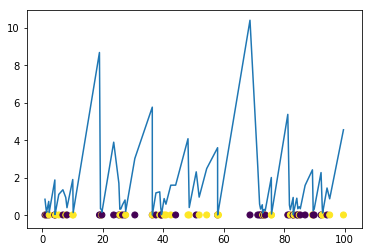

In [248]:
# Homo Poisson
paramsSSCT = [.2, -0.8, -.8]
dataSSCT = genSSCT(100, paramsSSCT)

y_vals = np.diff([0]+dataSSCT['t'])

plt.plot(dataSSCT['t'], y_vals)
plt.scatter(dataSSCT['t'], [min(y_vals)]*len(dataSSCT['t']), c=dataSSCT['x'])
# plt.show()

In [196]:
T=100
fn_param_pairs = [(genSSCT, paramsSSCT), (genHomPP, paramsHomPP), (genNonHomPP, paramsNonHomPP), (genHP, paramsHP), (genSCP, paramsSCP)]

In [211]:
def generate_data(n, T, fn_param_pairs):
    nperproc = n//len(fn_param_pairs)
    data = {'x': [], 't': []}
    for fn, params in fn_param_pairs:
        for _ in range(nperproc):
            data_i = fn(T, params)
            # Generate intervals
            intervals = np.diff([0]+data_i['t'])
            data_i['t'] = np.stack([intervals, data_i['t']]).T
            
            data['t'].append(data_i['t'])
            data['x'].append(data_i['x'])
            
    return data

In [212]:
def generate_synthethic_data_wrapper(n, T=100, shuffle=False):
    paramsSSCT_1 = [-.2, 0.8, -.8]
    paramsNonHomPP_1 = [.1]
    paramsHomPP_1 = [.4]
    paramsSCP_1 = [.5, .5]
    paramsHP_1 = [.9, .1, 1.]
    paramsSSCT_2 = [-.2, 0.8, -.8]
    paramsNonHomPP_2 = [.1]
    paramsHomPP_2 = [.4]
    paramsSCP_2 = [.5, .5]
    paramsHP_2 = [.9, .1, 1.]

    fn_param_pairs = [(genSSCT, paramsSSCT), (genHomPP, paramsHomPP), (genNonHomPP, paramsNonHomPP), (genHP, paramsHP), (genSCP, paramsSCP)]
    data = generate_data(n, T, fn_param_pairs)
    if shuffle:
        idxs = np.arange(len(data['x']))
        np.random.shuffle(idxs)
        data['x'] = [data['x'][i] for i in idxs]
        data['t'] = [data['t'][i] for i in idxs]
        
    print("Count:", len(data['x']))
    print("Length stats (min,max,mean,median):",np.min(list(map(len, data['x']))), np.max(list(map(len, data['x']))), np.mean(list(map(len, data['x']))), np.median(list(map(len, data['x']))))
    return data

In [213]:
data = generate_synthethic_data_wrapper(100, T)

In [222]:
np.min(list(map(len, data['x']))), np.max(list(map(len, data['x']))), np.mean(list(map(len, data['x'])))

(24, 104, 69.79)

In [226]:
d = {'x': [np.arange(i,i+10) for i in range(10)]}

In [241]:
idxs

array([7, 8, 1, 2, 5, 9, 6, 4, 0, 3])

In [240]:
d['x']

[array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])]

In [225]:
len(data['x'])

100

In [2]:
from utils_ import generate_hawkes, generate_autoregressive_data

# Visualize Intensities

In [3]:
def _visualize_intensity(intensities, num_series=10):
    """
    Input:
        intensities: Tensor of shape T x N
        num_series: (int) how many times series to plot
    """
    intensities = np.array(intensities)
    T, N = intensities.shape
    print(T,N)
    num_series = min(num_series, N)
    series_idxs = np.random.randint(low=0, high=N, size=num_series)
    plt.figure(figsize=(30,10))
    max_interval = intensities[:,series_idxs].max()
    
    for i, idx in enumerate(series_idxs):
        plt.subplot(num_series,1,i+1)
        plt.plot(intensities[:,idx])
        plt.ylim(0,max_interval)

100 160


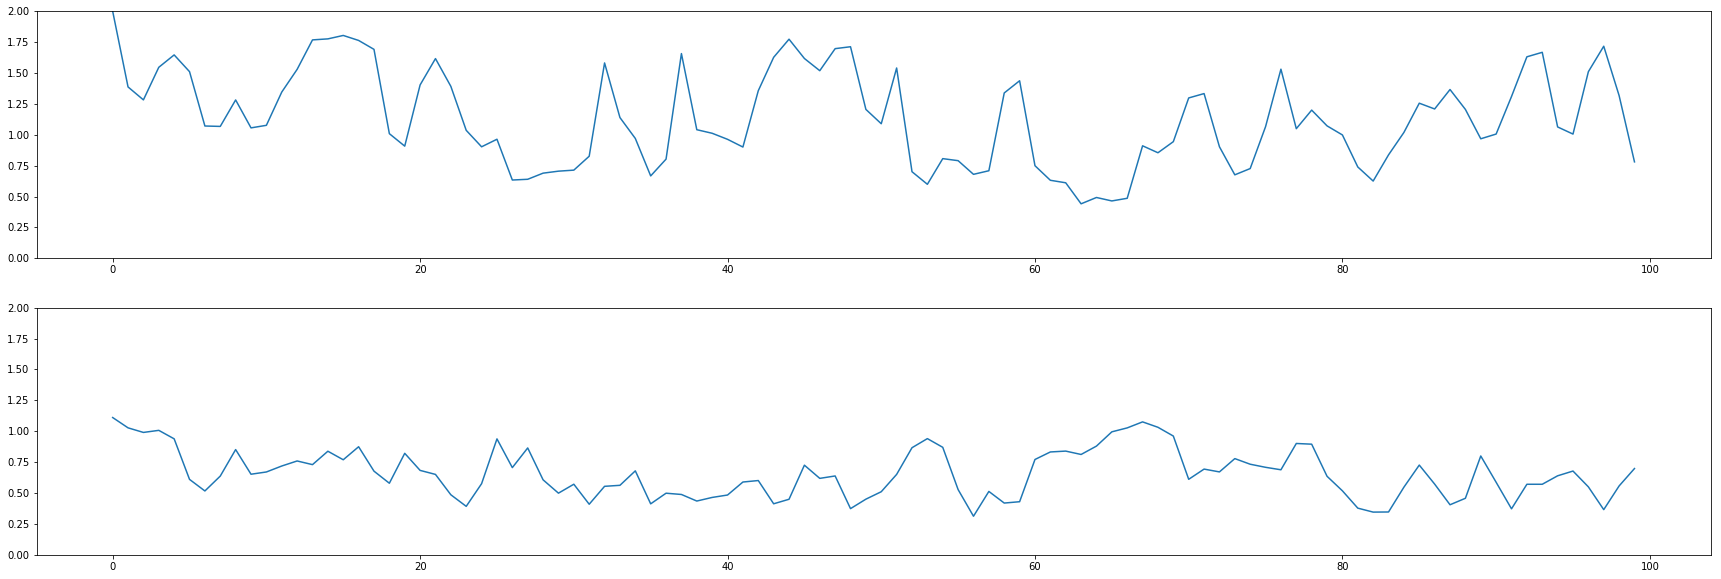

In [4]:
# Returns the time series and the modeling parameters

timeseries, info = generate_autoregressive_data(time_step=100, num_sample=80, num_clusters=2, debug=True)
# timeseries = generate_hawkes(time_step=100, num_sample=80, num_clusters=2)
# Extract only the intensities
# Shape: T x N
intensities = info['intensities']
_visualize_intensity(intensities, num_series=2)


# Visualize Timeseries

In [5]:
def visualize_points_series(timeseries, num_series=50):
    """
    Input:
        timeseries: Tensor of shape T x N
    """
    history = np.array(timeseries)
    T, N = history.shape
    print(T,N)
    num_series = min(num_series, N)
    series_idxs = np.random.randint(low=0, high=N, size=num_series)
    plt.figure(figsize=(15,10))
    for i, idx in enumerate(series_idxs):
        plt.scatter(history[:,idx], i+np.zeros(T))

100 160


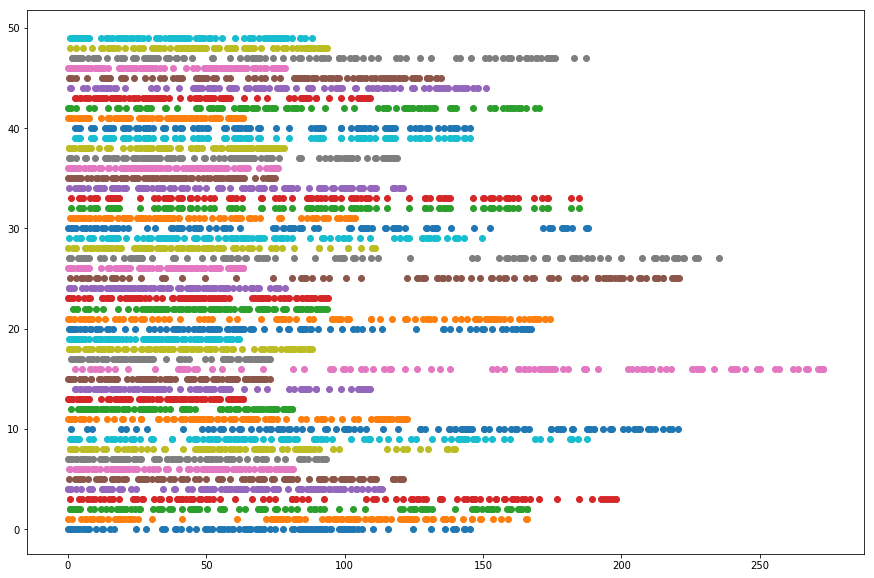

In [6]:
# Returns both the series and the intervals
# Shape: T x N x 2
timeseries, info = generate_autoregressive_data(time_step=100, num_sample=80, num_clusters=2, debug=True)
# timeseries = generate_hawkes(time_step=100, num_sample=80, num_clusters=2)
# Extract only the series
timeseries = timeseries[:,:,0]
visualize_points_series(timeseries)

# Visualize Intervals

## Interval Size: Sequential Plot

In [7]:
def visualize_intervals(intervals, num_series=5):
    """
    Input:
        timeseries: Tensor of shape T x N
    """
    intervals = np.array(intervals)
    T, N = intervals.shape
    print(T,N)
    num_series = min(num_series, N)
    series_idxs = np.random.randint(low=0, high=N, size=num_series)
    plt.figure(figsize=(30,10))
    max_interval = intervals[:,series_idxs].max()
    
    for i, idx in enumerate(series_idxs):
        plt.subplot(num_series,1,i+1)
        plt.plot(intervals[:,idx])
        plt.ylim(0,max_interval)

100 160


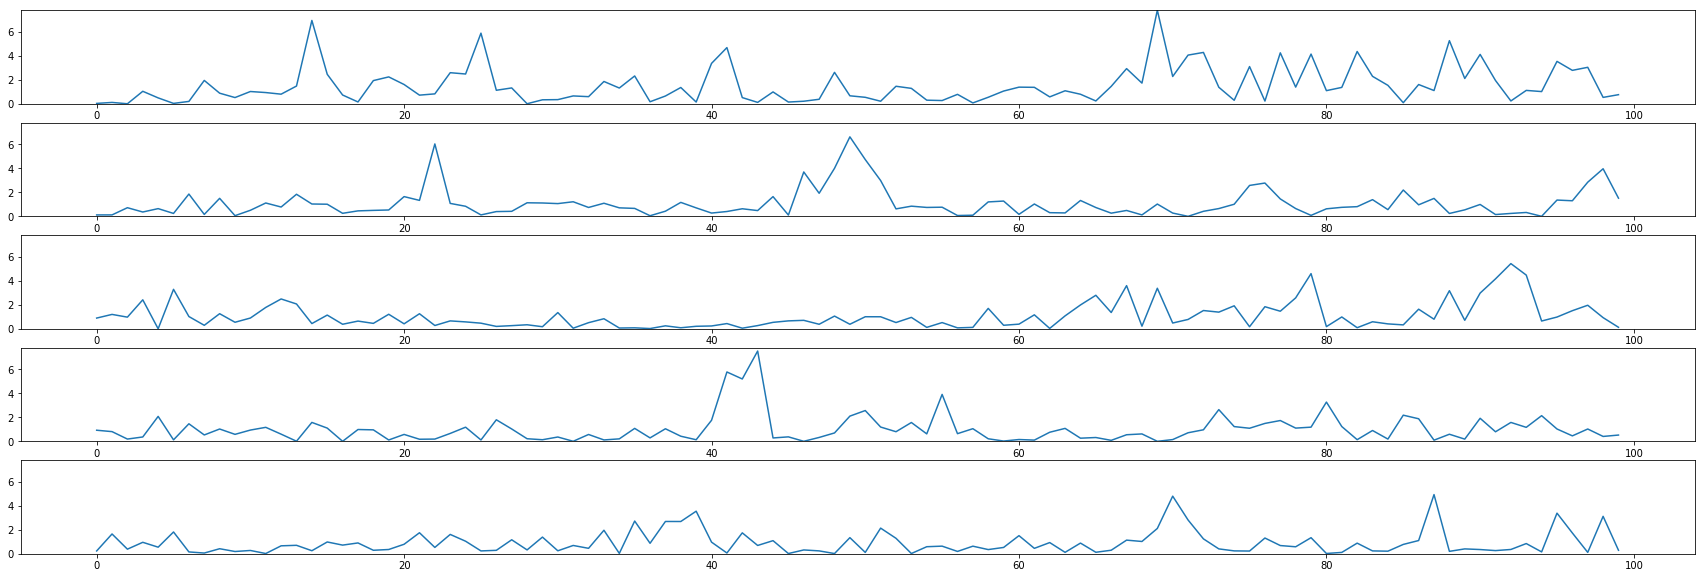

In [8]:
# Returns both the series and the intervals
# Shape: T x N x 2
_timeseries = generate_autoregressive_data(time_step=100, num_sample=80, num_clusters=2)
# _timeseries = generate_hawkes(time_step=100, num_sample=80, num_clusters=3)
# Extract only the intervals
intervals = _timeseries[:,:,1]
visualize_intervals(intervals, num_series=5)

## Interval Size: Histogram

In [9]:
def visualize_intervals_hist(intervals, num_series=5):
    """
    Input:
        timeseries: Tensor of shape T x N
    """
    intervals = np.array(intervals)
    T, N = intervals.shape
    print(T,N)
    num_series = min(num_series, N)
    series_idxs = np.random.randint(low=0, high=N, size=num_series)
    plt.figure(figsize=(30,10))
    max_interval = intervals[:,series_idxs].max()
    
    for i, idx in enumerate(series_idxs):
        plt.subplot(num_series,1,i+1)
        plt.hist(intervals[:,idx], bins=20)
#         plt.ylim(0,max_interval)

100 20


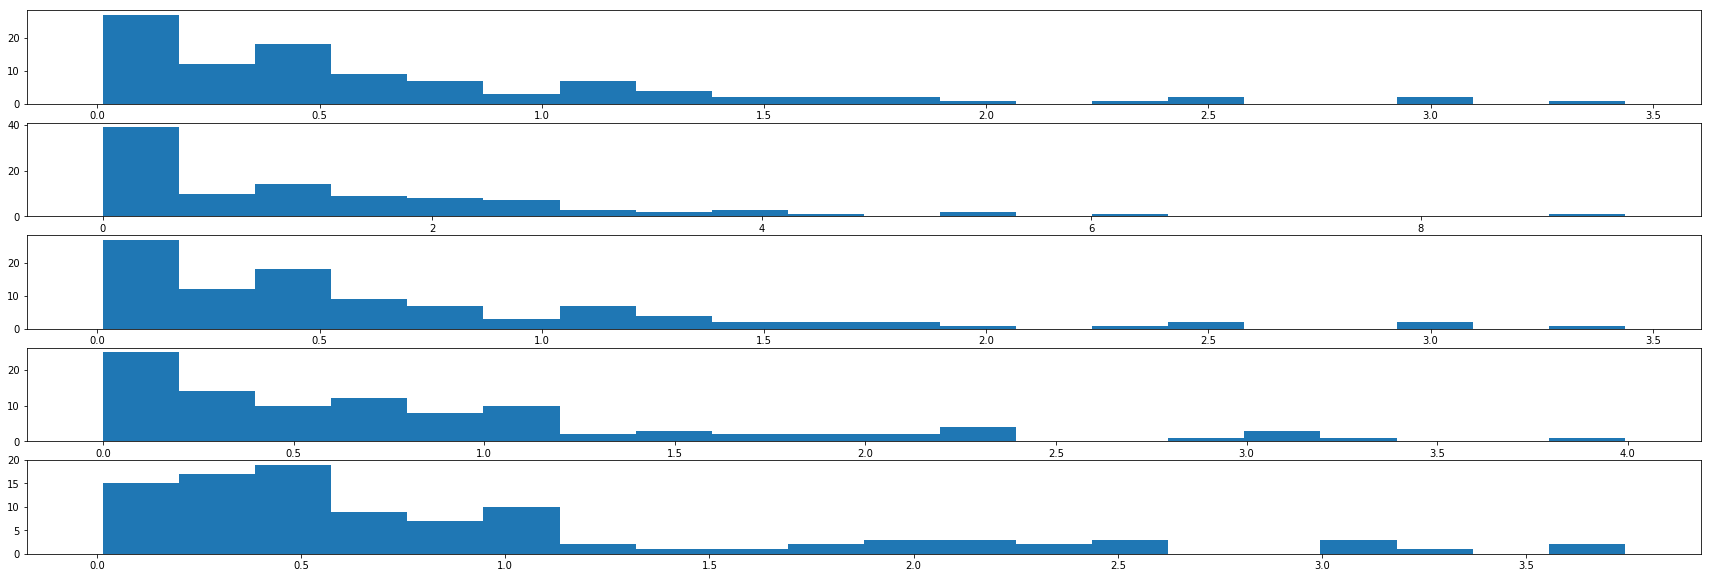

In [10]:
# Returns both the series and the intervals
# Shape: T x N x 2
_timeseries = generate_autoregressive_data(time_step=100, num_sample=10, num_clusters=2)
# _timeseries = generate_hawkes(time_step=100, num_sample=80, num_clusters=3)
# Extract only the intervals
intervals = _timeseries[:,:,1]
visualize_intervals_hist(intervals, num_series=5)